In [ ]:
!pip install -qqq git+https://github.com/chalk-diagrams/chalk git+https://github.com/srush/RASPy 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 3.8 MB/s eta 0:00:00


In [ ]:
from raspy import *
from raspy.rasp import Seq, Sel, SOp, Key, Query
from raspy.visualize import draw_all, draw, draw_sel
from chalk import *
from colour import Color
from raspy.visualize import word

def draw(c_inp=Color("white"), c_att=Color("white"), c_back=Color("white"), c_ffn=Color("white")):

    d =  box("Input", c_inp).named("inp") / vstrut(1) / (rectangle(3, 4).fill_color(c_back).named("main") +  ( box("Feed Forward", c_ffn).named("ffn") / vstrut(1) / box("Attention", c_att).named("att")).center_xy()) / vstrut(1) / box("Final").named("final")
    return d.connect_outside("inp", "main").connect_outside("ffn", "att").connect_outside("main", "final")

def draw_att():
    d = rectangle(2.5, 2.5)
    d = d.beside(box2("query", green).rotate_by(0.25).named("query"), -unit_x)
    d = d.beside(box2("key", orange).named("key"), -unit_y)
    d = d.beside(box2("output").rotate_by(-0.25).named("output"), unit_x)
    d = d.beside(box2("value", red).named("value"), unit_y)
    d = d + rectangle(0.4,0.4).fill_color(black).named("mid").translate(-0.5, 0)
    d = d + rectangle(0.4,0.4).fill_color(black).named("mid2").translate(0.5, 0)
    d = d.connect_perim("key", "mid", unit_y, -unit_y).connect_outside("query", "mid").connect_outside("mid", "mid2").connect_perim("value", "mid2", -unit_y, unit_y).connect_outside("mid2", "output")
    return d
set_svg_height(400)

\Relevant to the in-context preference learning project would be to assess whether or not there is a RASP program that can identify a phase transition from a token sequence of $(p,h(p))$ pairs where $p \in (0,1)$ and $h(p) : (0,1) \to \lbrace 0 , 1 \rbrace$ is a monotone decision rule. 

There is a RASP program that can sort a list of unique real numbers. So without loss of generality, we can assume the positional encoding encodes the relative ordering of the $p_i$ and so our problem is to find the last index such that $h(p_i) = 0$. 

In [ ]:
# This is a RASP-like method that will take in labels
# with x assumed to be sorted by p(y = 1 | x)
# so that positional encoding gives ranking
# Outputs index as int
def identify_threshold(data, labels):

  #if len(data) != len(labels):
  #  raise Exception("Lengths don't match")
  #if not all(data[i] <= data[i+1] for i in range(len(data) - 1)):
  #  raise Exception("Data is not sorted")
  #if not all(labels[i] <= labels[i+1] for i in range(len(labels) - 1)):
  #  raise Exception("Labels are not sorted")

  tokens.input(labels)
  length = len(labels)
  attn1 = (query(indices) <= key(indices)) & (query(indices) >= key(indices-1))
  sel1 = attn1.value(tokens)
  attn2 = (query(1) == key(sel1))
  sel2 = attn2.value(indices*(indices != length-1))
  return sel2

likelihood = [0.1,0.3,0.6,0.8,0.9]
labels = [0,0,0,1,1]
threshold_index = identify_threshold(likelihood,labels)(labels).val[0]
print(threshold_index)

2


Note, we'll need to pad head/tail of inputs with trivial input/output so that left boundary has zero label always and right boundary has one label always. We can also visualize the attention patterns here.

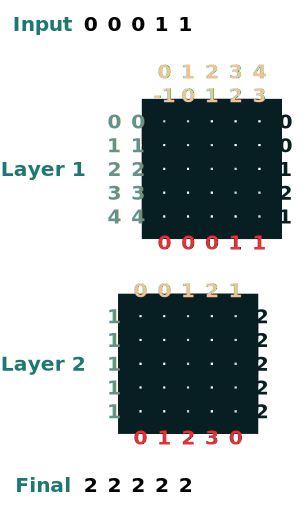

In [ ]:
likelihood = [0.1,0.3,0.6,0.8,0.9]
labels = [0,0,0,1,1]
identify_threshold(likelihood,labels)(labels)

 The code above will work whenever we have access to the ground-truth likelihoods and the decision rule is binary monotone in the likelihood. To proceed we'll want to setup a method to sample data and a threshold to produce labels, another method to sort using likelihood, and a final method that compares likelihood[threshold_index] with the sampled threshold. Note that there is a boundary condition that needs to be implemented before sending to the method to avoid edge cases. 


In [ ]:
import random
import numpy as np
def sample_data(size):
   # we sample some random likelihoods and a decision threshold
   likelihood = sorted([random.uniform(0, 1) for _ in range(size)])
   threshold = random.uniform(0, 1)
   labels = [int(l >= threshold) for l in likelihood]
   return likelihood, labels, threshold
   
def likelihood_sorted(likelihood, labels): 
  data = list([(0,0)]+sorted(zip(likelihood, labels))+[(1,1)])
  #data.sort()
  sorted_likelihoods, sorted_labels = zip(*data)
  return sorted_likelihoods, sorted_labels

def evaluate_threshold(likelihood, labels, threshold):
  #threshold_index = labels.index(1)
  if identify_threshold(likelihood, labels)(labels).val[0] >= len(likelihood)-1:
    thresh_hat = 1
  else:
    thresh_hat = likelihood[identify_threshold(likelihood, labels)(labels).val[0]]
  #print(thresh_hat)
  loss = np.abs(threshold - thresh_hat)
  return loss

# Plot size of dataset vs estimated error relative to threshold 
(more samples -> lower error)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

More readable fonts

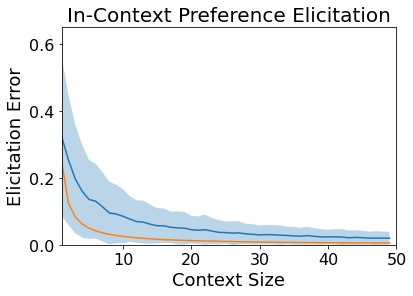

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.xlabel("Context Size")
plt.ylabel("Elicitation Error")

def plot_error(size):
  num_trials = 1000
  errors=[]
  for i in range(num_trials):
    likelihood, labels, threshold = sample_data(size)
    sorted_likelihoods, sorted_labels = likelihood_sorted(likelihood, labels)
    errors += [evaluate_threshold(sorted_likelihoods, sorted_labels, threshold)]
  error = sum(errors)/num_trials
  return error, np.std(errors)



sizes=[]
errors=[]
std_errors=[]
for size in range(1, 50, 1):
  error, std_error = plot_error(size)
  sizes.append(size)
  errors.append(error)
  std_errors.append(std_error)
plt.plot(sizes, errors)
plt.plot(sizes, 0.25 / np.array(sizes))
plt.fill_between(sizes, np.array(errors)-np.array(std_errors), np.array(errors)+np.array(std_errors), alpha=0.3)

ax = plt.gca()
ax.set_ylim([0, 0.65])
ax.set_xlim([1, 50])
plt.title("In-Context Preference Elicitation")
plt.show()



  

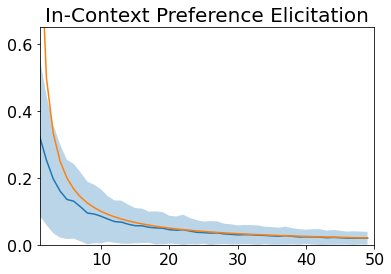

In [ ]:
plt.plot(sizes, errors)
plt.plot(sizes, 1 / np.array(sizes))
plt.fill_between(sizes, np.array(errors)-np.array(std_errors), np.array(errors)+np.array(std_errors), alpha=0.3)

ax = plt.gca()
ax.set_ylim([0, 0.65])
ax.set_xlim([1, 50])
plt.title("In-Context Preference Elicitation")
plt.show()

0.0
0.1
0.5


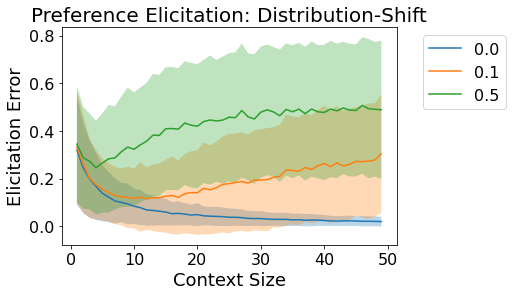

In [ ]:
import matplotlib.pyplot as plt

def uncertain_sample_data(size, gamma):
   # we sample some random likelihoods and a decision threshold
   likelihood = sorted([random.uniform(0, 1) for _ in range(size)])
   threshold = random.uniform(0, 1)
   labels = [int(l >= threshold) if l < threshold - gamma or l> threshold + gamma else int(l >= random.uniform(threshold-gamma, threshold+gamma))for l in likelihood]
   return likelihood, labels, threshold
def noisy_plot_error(size, gamma = 0):
  num_trials = 1000
  errors=[]
  for i in range(num_trials):
    likelihood, labels, threshold = uncertain_sample_data(size, gamma)
    sorted_likelihoods, sorted_labels = likelihood_sorted(likelihood, labels)
    errors += [evaluate_threshold(sorted_likelihoods, sorted_labels, threshold)]
  error = sum(errors)/num_trials
  return error, np.std(errors)
plt.figure()

gammas = [0.0, 0.1, 0.5]
for gamma in gammas:
  print(gamma)
  sizes=[]
  errors=[]
  std_errors=[]
  for size in range(1, 50, 1):
    error, std_error = noisy_plot_error(size, gamma)
    sizes.append(size)
    errors.append(error)
    std_errors.append(std_error)
  plt.plot(sizes, errors, label=gamma)
  plt.fill_between(sizes, np.array(errors)-np.array(std_errors), np.array(errors)+np.array(std_errors), alpha=0.3)

ax=plt.gca()
plt.xlabel("Context Size")
plt.ylabel("Elicitation Error")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right',
          ncol=1, fancybox=True, bbox_to_anchor=(1.35, 1.0))
plt.title("Preference Elicitation: Distribution-Shift")
plt.show()
  